In [3]:
# %pip install pandas numpy matplotlib pyarrow fastparquet  # (uncomment if needed)

import os, re, glob
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 60)

In [4]:
# === PATHS ===
ACTUALS_CSV = "/home/renga/Desktop/data_neoen/data/measurements_neoen_morcenx_sep2025.csv"   # put full path if not in CWD
FORECAST_DIR = Path("/home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx")

# === FORECAST FILE NAMING ===
# Example: forecast_202510070515.csv  -> run time = 2025-10-07 05:15 UTC
FC_PATTERN = "forecast_*.csv"
FC_TS_REGEX = re.compile(r"forecast_(\d{12})\.csv")  # captures YYYYMMDDHHMM

# === COLUMN NAMES ===
ACTUALS_TIME_COL = "measure_date"
ACTUALS_PROD_COL = "prod"  # we're focusing on production

FC_TARGET_COL = "horizon"      # tz-aware UTC timestamps like '2025-07-07 14:15:00+00:00'
FC_DET_COL    = "deterministic"
FC_CLEAR_SKY  = "clear_sky"

# Quantiles we’ll read from forecast files
FC_QUANT_COLS = [
    "p_05","p_10","p_15","p_20","p_25","p_30","p_35","p_40","p_45",
    "p_50","p_55","p_60","p_65","p_70","p_75","p_80","p_85","p_90","p_95"
]

# Convenience subsets
FC_P10_COL, FC_P50_COL, FC_P90_COL = "p_10", "p_50", "p_90"

# Analysis window for actuals (optional, speeds things up). Use UTC date strings.
DATE_MIN = None  # e.g., "2025-09-01"
DATE_MAX = None  # e.g., "2025-09-30"


In [5]:
actuals = pd.read_csv(ACTUALS_CSV, parse_dates=[ACTUALS_TIME_COL])

# Ensure tz-aware UTC (your sample already is, but this keeps it robust)
if actuals[ACTUALS_TIME_COL].dtype.tz is None:
    actuals[ACTUALS_TIME_COL] = actuals[ACTUALS_TIME_COL].dt.tz_localize("UTC")
else:
    # Normalize to UTC in case it’s another tz (unlikely given +00:00)
    actuals[ACTUALS_TIME_COL] = actuals[ACTUALS_TIME_COL].dt.tz_convert("UTC")

# Optional date window
if DATE_MIN:
    actuals = actuals[actuals[ACTUALS_TIME_COL] >= pd.to_datetime(DATE_MIN, utc=True)]
if DATE_MAX:
    actuals = actuals[actuals[ACTUALS_TIME_COL] <= pd.to_datetime(DATE_MAX, utc=True)]

# --- Keep only exact 15-minute grid points (…:00, :15, :30, :45) ---
# This is a strict filter (no averaging), matching your forecast cadence.
mask_15 = (
    (actuals[ACTUALS_TIME_COL].dt.minute % 15 == 0) &
    (actuals[ACTUALS_TIME_COL].dt.second == 0) &
    (actuals[ACTUALS_TIME_COL].dt.microsecond == 0)
)
actuals_15 = actuals.loc[mask_15].copy()

# Keep only time + prod (adjust if you need more columns later)
actuals_15 = actuals_15[[ACTUALS_TIME_COL, ACTUALS_PROD_COL]].sort_values(ACTUALS_TIME_COL).reset_index(drop=True)

display(actuals_15.head(8))
# print("Actual rows at 15-min cadence:", len(actuals_15))


,measure_date,prod
0,2025-09-01 00:00:00+00:00,0.0
1,2025-09-01 00:15:00+00:00,0.0
2,2025-09-01 00:30:00+00:00,0.0
3,2025-09-01 00:45:00+00:00,0.0
4,2025-09-01 01:00:00+00:00,0.0
5,2025-09-01 01:15:00+00:00,0.0
6,2025-09-01 01:30:00+00:00,0.0
7,2025-09-01 01:45:00+00:00,0.0


In [6]:
def run_time_to_filename(run_ts_utc: pd.Timestamp) -> Path:
    """Make forecast filename from a UTC run timestamp (rounded to 15 min)."""
    if run_ts_utc.tz is None:
        run_ts_utc = run_ts_utc.tz_localize("UTC")
    ts_str = run_ts_utc.strftime("%Y%m%d%H%M")  # YYYYMMDDHHMM
    return FORECAST_DIR / f"forecast_{ts_str}.csv"

def filename_to_run_time(path: Path) -> pd.Timestamp:
    m = FC_TS_REGEX.match(path.name)
    if not m:
        raise ValueError(f"Unexpected forecast filename: {path.name}")
    ts = datetime.strptime(m.group(1), "%Y%m%d%H%M")
    return pd.Timestamp(ts, tz="UTC")

def safe_read_forecast(path: Path, usecols=None) -> pd.DataFrame | None:
    """Read a forecast CSV, or return None if missing/empty/bad."""
    if not path.exists():
        return None
    try:
        df = pd.read_csv(path, parse_dates=[FC_TARGET_COL], usecols=usecols)
        # Ensure target is tz-aware UTC; if not, localize (adjust if they’re local)
        if df[FC_TARGET_COL].dtype.tz is None:
            df[FC_TARGET_COL] = df[FC_TARGET_COL].dt.tz_localize("UTC")
        return df
    except Exception as e:
        print(f"Warning: skipping {path.name}: {e}")
        return None


In [7]:
def collect_forecasts_for_target(target_ts_utc: pd.Timestamp) -> pd.DataFrame:
    """
    For a given target timestamp (UTC), fetch the predictions for that target
    from all run files whose forecast horizon includes the target (last 48h).
    Returns a tidy DataFrame: one row per run_time with deterministic, clear_sky, quantiles, and lead_hours.
    """
    if target_ts_utc.tz is None:
        target_ts_utc = target_ts_utc.tz_localize("UTC")

    run_start = target_ts_utc - pd.Timedelta(hours=48)
    run_times = pd.date_range(run_start, target_ts_utc, freq="15min", tz="UTC")

    rows = []
    usecols = [FC_TARGET_COL, FC_DET_COL, FC_CLEAR_SKY] + FC_QUANT_COLS

    for run_ts in run_times:
        path = run_time_to_filename(run_ts)
        df = safe_read_forecast(path, usecols=usecols)
        if df is None or df.empty:
            continue

        # Extract the row where horizon equals our target time
        # (exact match; if your CSV timestamps differ in rounding, consider a tolerance)
        matched = df.loc[df[FC_TARGET_COL] == target_ts_utc]
        if matched.empty:
            continue

        row = matched.iloc[0].to_dict()
        row["run_time"] = run_ts
        row["target_time"] = target_ts_utc
        row["lead_hours"] = (target_ts_utc - run_ts).total_seconds() / 3600.0
        rows.append(row)

    if not rows:
        return pd.DataFrame(columns=["run_time","target_time","lead_hours", FC_DET_COL, FC_CLEAR_SKY] + FC_QUANT_COLS)

    out = pd.DataFrame(rows).sort_values("run_time").reset_index(drop=True)
    return out


In [11]:
# Manually set your target timestamp (must exist in actuals_15) ---

# Example: paste the exact timestamp from your data (UTC, tz-aware).
TARGET_TS_STR = "2025-09-14 15:15:00+00:00"  # <- change this

TARGET_TS = pd.to_datetime(TARGET_TS_STR, utc=True)

# Validate it exists in actuals_15
if not (actuals_15[ACTUALS_TIME_COL] == TARGET_TS).any():
    # Show a hint of nearby options if not found
    print(f"[Warning] {TARGET_TS} not found in actuals_15.")
    # Suggest the closest available timestamp
    diffs = (actuals_15[ACTUALS_TIME_COL] - TARGET_TS).abs()
    closest_idx = diffs.argmin()
    print("Closest available:", actuals_15.loc[closest_idx, ACTUALS_TIME_COL])

print("Target timestamp:", TARGET_TS)

fc_target = collect_forecasts_for_target(TARGET_TS)
display(fc_target.head(5))
print("Forecast runs found:", len(fc_target), "(expected up to 192 if all files exist)")


Target timestamp: 2025-09-14 15:15:00+00:00


,horizon,p_05,p_10,p_15,p_20,p_25,p_30,p_35,p_40,p_45,p_50,p_55,p_60,p_65,p_70,p_75,p_80,p_85,p_90,p_95,clear_sky,deterministic,run_time,target_time,lead_hours
0,2025-09-14 15:15:00+00:00,987.141347,1273.622514,1579.726596,1838.254776,1967.255122,2146.799134,2253.348488,2477.303192,2623.573309,2761.501006,3021.382981,3796.911914,4101.233950,5320.413221,8322.328504,12902.642203,13341.404768,13466.537077,13910.933298,13081.101849,4633.834755,2025-09-12 15:15:00+00:00,2025-09-14 15:15:00+00:00,48.00
1,2025-09-14 15:15:00+00:00,915.518129,1134.792742,1424.954085,1710.348981,1831.575836,1994.589538,2106.800575,2332.734876,2461.004223,2560.494295,2823.995469,3220.301917,3857.398907,4965.457873,7054.868943,12462.554688,13116.907300,13266.877130,13689.795961,13121.362526,4435.941863,2025-09-12 15:30:00+00:00,2025-09-14 15:15:00+00:00,47.75
2,2025-09-14 15:15:00+00:00,712.422831,800.681139,951.475199,1183.363720,1374.404720,1479.192014,1563.869894,1675.378410,1766.552100,1849.766472,1930.423340,2008.803955,2303.859676,2390.360082,2927.379370,4097.723754,6355.266349,9099.699396,13434.616801,13121.362526,2652.867921,2025-09-12 16:00:00+00:00,2025-09-14 15:15:00+00:00,47.25
3,2025-09-14 15:15:00+00:00,664.795739,795.455035,960.258366,1231.171004,1421.081170,1503.150363,1593.908499,1710.038641,1809.309481,1875.860295,1968.523191,2188.120785,2326.809054,2489.771677,3211.668182,5144.749063,7086.969032,9300.396228,13425.927047,13121.362526,2765.282654,2025-09-12 16:15:00+00:00,2025-09-14 15:15:00+00:00,47.00
4,2025-09-14 15:15:00+00:00,545.074551,655.969078,842.540371,1035.977046,1223.984713,1325.923885,1406.854076,1516.019668,1653.483123,1711.824853,1790.234714,1929.338404,2098.571816,2199.795934,2798.109257,4143.127005,6364.632576,9241.872681,13309.676319,13121.362526,2509.725128,2025-09-12 16:30:00+00:00,2025-09-14 15:15:00+00:00,46.75


Forecast runs found: 191 (expected up to 192 if all files exist)


In [12]:
# Errors per run + MAE/RMSE summaries (for the chosen TARGET_TS)

# 1) Actual value at the target timestamp
actual_val = float(actuals_15.loc[actuals_15[ACTUALS_TIME_COL] == TARGET_TS, ACTUALS_PROD_COL].iloc[0])
print("Target timestamp:", TARGET_TS)
print("Actual prod at target:", actual_val)

# 2) Choose which forecast columns to evaluate
forecast_cols = [FC_DET_COL, FC_CLEAR_SKY] + FC_QUANT_COLS  # includes deterministic, clear_sky, and all p_*
# If you want a smaller set, use something like:
# forecast_cols = [FC_DET_COL, FC_CLEAR_SKY, FC_P10_COL, FC_P50_COL, FC_P90_COL]

# 3) Long/tidy table of per-run forecasts at this target
err_long = (
    fc_target[["run_time", "lead_hours"] + forecast_cols]
    .melt(id_vars=["run_time","lead_hours"], var_name="forecast_type", value_name="forecast_value")
    .sort_values(["forecast_type","run_time"])
    .reset_index(drop=True)
)

# 4) Add errors vs actual
err_long["error"] = err_long["forecast_value"] - actual_val
err_long["abs_error"] = err_long["error"].abs()
err_long["squared_error"] = err_long["error"]**2

# 5) Per-run table (each row is one forecast run for this target)
print("\nPer-run errors (head):")
display(err_long.head(12))

# 6) Summary metrics across ALL runs for this target (MAE, RMSE, Bias) by forecast type
summary_by_type = (
    err_long
    .groupby("forecast_type", as_index=False)
    .agg(
        n_runs=("error","size"),
        MAE=("abs_error","mean"),
        RMSE=("squared_error", lambda s: (s.mean())**0.5),
        Bias=("error","mean")
    )
    .sort_values("MAE")
)

print("\nSummary metrics across runs for this target:")
display(summary_by_type)

# 7) (Optional) Metrics vs lead time bins — to see how each type behaves as horizon shrinks
err_long["lead_hr_bin"] = err_long["lead_hours"].round(0)
summary_by_lead = (
    err_long
    .groupby(["forecast_type","lead_hr_bin"], as_index=False)
    .agg(
        n=("error","size"),
        MAE=("abs_error","mean"),
        RMSE=("squared_error", lambda s: (s.mean())**0.5),
        Bias=("error","mean")
    )
    .sort_values(["forecast_type","lead_hr_bin"])
)

print("\nMAE/RMSE vs lead time (per type):")
display(summary_by_lead.head(20))


Target timestamp: 2025-09-14 15:15:00+00:00
Actual prod at target: 5721.595

Per-run errors (head):


,run_time,lead_hours,forecast_type,forecast_value,error,abs_error,squared_error
0,2025-09-12 15:15:00+00:00,48.00,clear_sky,13081.101849,7359.506849,7359.506849,5.416234e+07
1,2025-09-12 15:30:00+00:00,47.75,clear_sky,13121.362526,7399.767526,7399.767526,5.475656e+07
2,2025-09-12 16:00:00+00:00,47.25,clear_sky,13121.362526,7399.767526,7399.767526,5.475656e+07
3,2025-09-12 16:15:00+00:00,47.00,clear_sky,13121.362526,7399.767526,7399.767526,5.475656e+07
4,2025-09-12 16:30:00+00:00,46.75,clear_sky,13121.362526,7399.767526,7399.767526,5.475656e+07
5,2025-09-12 16:45:00+00:00,46.50,clear_sky,13121.362526,7399.767526,7399.767526,5.475656e+07
6,2025-09-12 17:00:00+00:00,46.25,clear_sky,13120.309038,7398.714038,7398.714038,5.474097e+07
7,2025-09-12 17:15:00+00:00,46.00,clear_sky,13119.252859,7397.657859,7397.657859,5.472534e+07
8,2025-09-12 17:30:00+00:00,45.75,clear_sky,13119.252859,7397.657859,7397.657859,5.472534e+07
9,2025-09-12 17:45:00+00:00,45.50,clear_sky,13119.252859,7397.657859,7397.657859,5.472534e+07



Summary metrics across runs for this target:


,forecast_type,n_runs,MAE,RMSE,Bias
1,deterministic,191,1216.337251,1476.062173,263.243348
11,p_50,191,1930.547023,2228.857026,-458.244059
10,p_45,191,1979.477896,2230.183272,-1098.079610
12,p_55,191,2055.071761,2486.419976,348.658455
9,p_40,191,2181.803218,2475.120621,-1801.076268
8,p_35,191,2439.674331,2685.751851,-2270.435115
13,p_60,191,2566.526887,3061.736290,1265.168755
7,p_30,191,2792.949401,2957.366588,-2754.923061
6,p_25,191,3202.418878,3289.735134,-3202.418878
14,p_65,191,3229.103215,3734.522720,2284.032974



MAE/RMSE vs lead time (per type):


,forecast_type,lead_hr_bin,n,MAE,RMSE,Bias
0,clear_sky,0.0,2,7576.40435,7576.40435,7576.40435
1,clear_sky,1.0,3,7576.40435,7576.40435,7576.40435
2,clear_sky,2.0,5,7576.40435,7576.40435,7576.40435
3,clear_sky,3.0,3,7576.40435,7576.40435,7576.40435
4,clear_sky,4.0,5,7576.40435,7576.40435,7576.40435
5,clear_sky,5.0,3,7576.40435,7576.40435,7576.40435
6,clear_sky,6.0,5,7576.40435,7576.40435,7576.40435
7,clear_sky,7.0,3,7576.40435,7576.40435,7576.40435
8,clear_sky,8.0,5,7576.40435,7576.40435,7576.40435
9,clear_sky,9.0,3,7576.40435,7576.40435,7576.40435


Actual prod at target: 5721.595


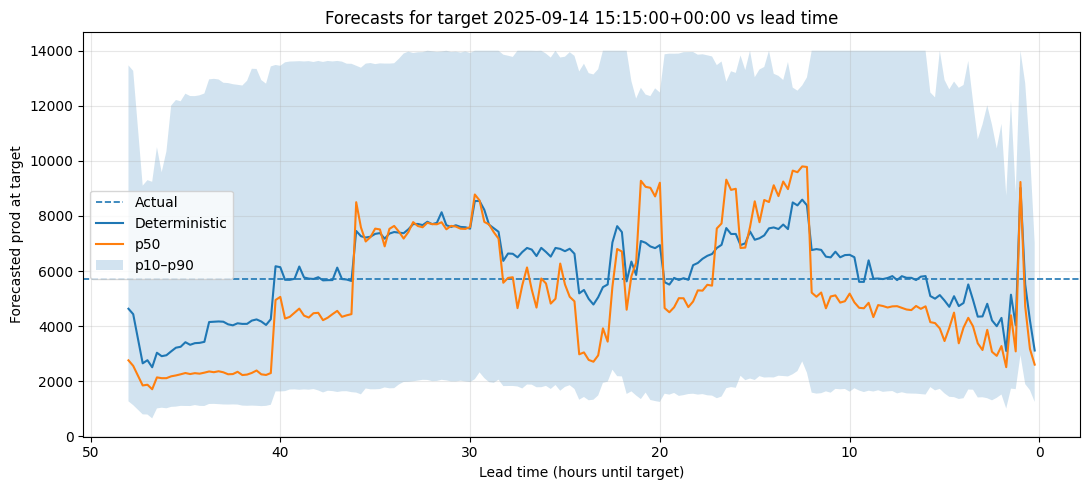

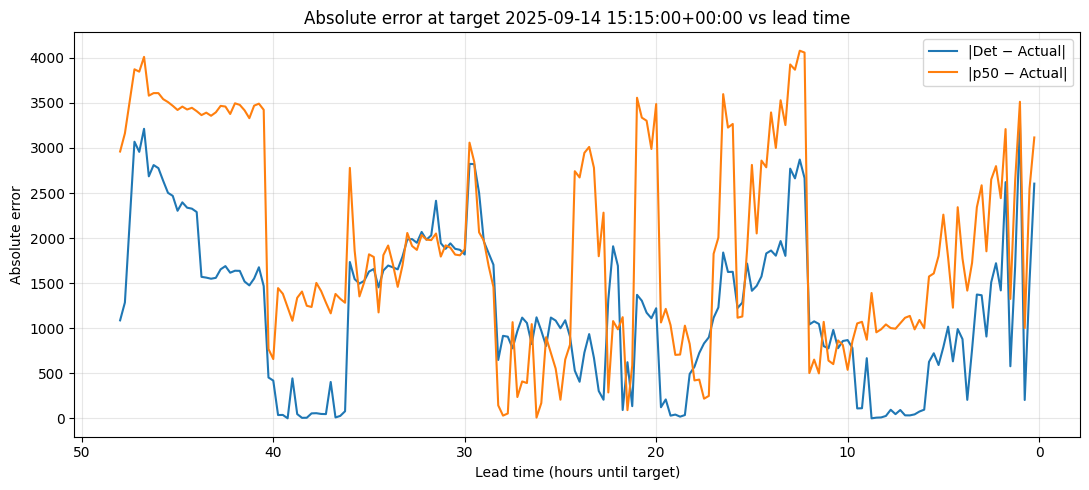

In [13]:
# Grab actual prod at that target
actual_val = float(actuals.loc[actuals[ACTUALS_TIME_COL] == TARGET_TS, ACTUALS_PROD_COL].iloc[0])
print("Actual prod at target:", actual_val)

df_plot = fc_target.copy()
df_plot["err_det"] = df_plot[FC_DET_COL] - actual_val
df_plot["err_p50"] = df_plot[FC_P50_COL] - actual_val

# --- Visualization: predictions vs lead time ---
plt.figure(figsize=(11,5))
plt.axhline(actual_val, linestyle="--", label="Actual", linewidth=1.2)
plt.plot(df_plot["lead_hours"], df_plot[FC_DET_COL], label="Deterministic")
plt.plot(df_plot["lead_hours"], df_plot[FC_P50_COL], label="p50")
# Optionally add an uncertainty ribbon from p10 to p90 across runs (at this single target time)
plt.fill_between(df_plot["lead_hours"], df_plot[FC_P10_COL], df_plot[FC_P90_COL], alpha=0.2, label="p10–p90")
plt.gca().invert_xaxis()  # so 48h → 0h (left to right)
plt.xlabel("Lead time (hours until target)")
plt.ylabel("Forecasted prod at target")
plt.title(f"Forecasts for target {TARGET_TS} vs lead time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Visualization: absolute error vs lead time (which is closer) ---
plt.figure(figsize=(11,5))
plt.plot(df_plot["lead_hours"], df_plot["err_det"].abs(), label="|Det − Actual|")
plt.plot(df_plot["lead_hours"], df_plot["err_p50"].abs(), label="|p50 − Actual|")
plt.gca().invert_xaxis()
plt.xlabel("Lead time (hours until target)")
plt.ylabel("Absolute error")
plt.title(f"Absolute error at target {TARGET_TS} vs lead time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
